# MINFLUX Power Spectrum Analysis
This notebook performs Lomb-Scargle and FFT analysis on bead localization data to detect periodicities.

In [9]:
import ipywidgets as widgets
from IPython.display import display
import numpy as np
import io
import matplotlib.pyplot as plt
from scipy.fftpack import fft, fftfreq
from scipy.interpolate import interp1d
from astropy.timeseries import LombScargle
from google.colab import files

# Set plotting style
%matplotlib inline

### 1. File Configuration
Change the filename in the cell below to process different datasets.

In [ ]:
#native colab file upload dialog
print("Please upload your MINFLUX .npy file:")
uploaded = files.upload()

#get the filename and data from the uploaded dictionary
if not uploaded:
    print("No file was uploaded.")
else:
    #take the first file uploaded
    filename = list(uploaded.keys())[0]
    content = uploaded[filename]

    #load the NumPy data from memory
    mfx_data = np.load(io.BytesIO(content))
    file_list = [mfx_data]
    num = 0 # Default index

    #labels using a simple input prompt
    user_input = input("Enter labels separated by commas (e.g., x-axis, y-axis): ")
    if user_input.strip():
        labels = [l.strip() for l in user_input.split(',')]
    else:
        labels = ['x-axis', 'y-axis']

    print(f"\nSuccessfully loaded: {filename}")
    print(f"Data Shape: {mfx_data.shape}")
    print(f"Labels assigned: {labels}")
    print("\nReady! You can now run the next cell.")

Please upload your MINFLUX .npy file:


Saving 250918-123344_minflux_agg1000.npy to 250918-123344_minflux_agg1000.npy
Enter labels separated by commas (e.g., x-axis, y-axis): james, henry

Successfully loaded: 250918-123344_minflux_agg1000.npy
Data Shape: (5209,)
Labels assigned: ['james', 'henry']

Ready! You can now run the next cell.


### 2. Simple Test Case
This section uses generated synthetic data to verify that the Lomb-Scargle summation works correctly.

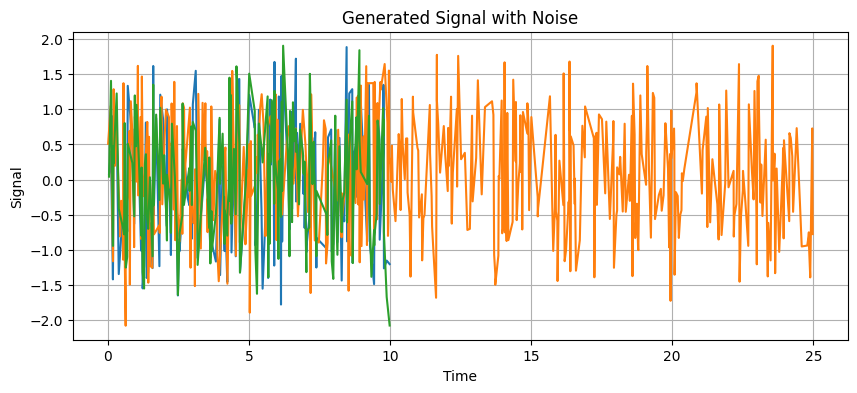

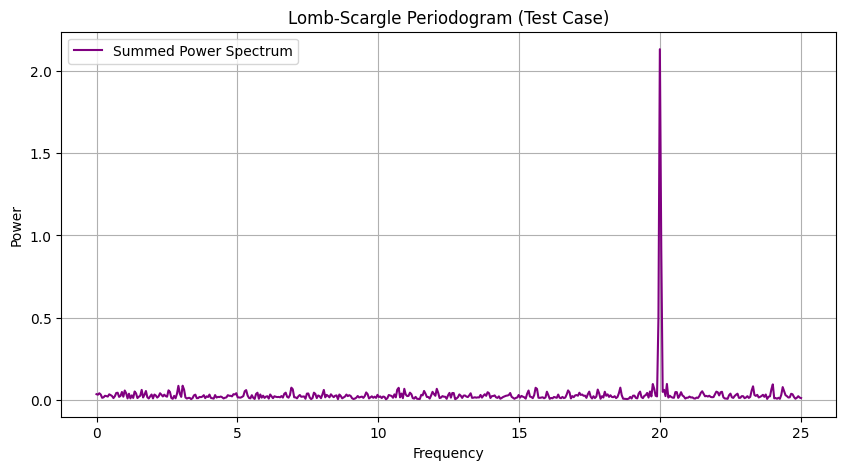

In [4]:
# Generate sample data
np.random.seed(0)
test_frequency = 20
t1 = np.sort(np.random.uniform(0, 10, 200))  # Uneven time points
y1 = np.sin(test_frequency * 2 * np.pi * t1) + 0.4 * np.random.standard_normal(200)

np.random.seed(45)
t3 = np.sort(np.random.uniform(0, 10, 200))
y3 = np.sin(test_frequency * 2 * np.pi * t1) + 0.4 * np.random.standard_normal(200)

t2 = np.sort(np.random.uniform(0, 25, 500))
y2 = np.sin(test_frequency * 2 * np.pi * t2) + 0.4 * np.random.standard_normal(500)

tall = [t1, t2, t1]
yall = [y1, y2, y3]

# Plot the raw data
plt.figure(figsize=(10, 4))
for i in range(len(tall)):
    plt.plot(tall[i], yall[i])
plt.xlabel("Time")
plt.ylabel("Signal")
plt.title("Generated Signal with Noise")
plt.grid(True)
plt.show()

# Common frequency grid
common_frequency = np.linspace(0, 25, 500)
summed_power = np.zeros_like(common_frequency)

for i in range(len(tall)):
    t, y = tall[i], yall[i]
    frequency, power = LombScargle(t, y).autopower()
    power_interp = np.interp(common_frequency, frequency, power)
    summed_power += power_interp

# Plot result
fig, ax = plt.subplots(figsize=(10, 5))
ax.plot(common_frequency, summed_power, label="Summed Power Spectrum", color='purple')
ax.set_xlabel("Frequency")
ax.set_ylabel("Power")
ax.set_title("Lomb-Scargle Periodogram (Test Case)")
ax.legend()
ax.grid(True)
plt.show()

### 3. Experimental Data Analysis
Processing the loaded MINFLUX data.

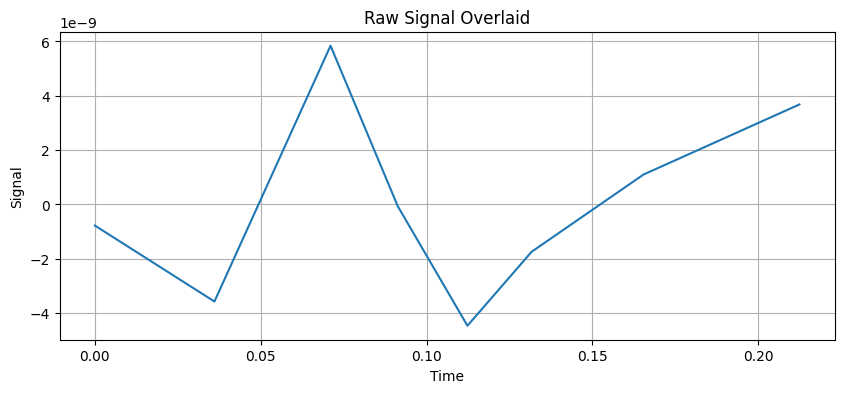

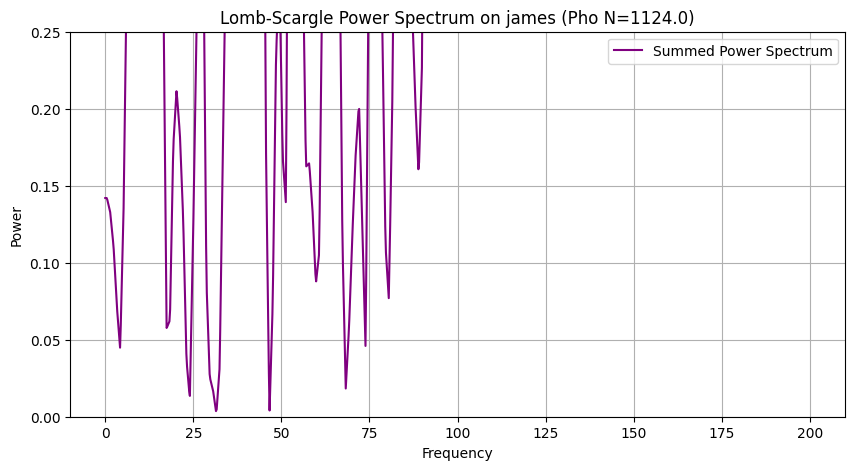

In [11]:
mfx = file_list[num]
u_tid = np.unique(mfx['tid'])
cutoff = 100

common_frequency = np.linspace(0, 200, 1000)
summed_power = np.zeros_like(common_frequency)

num_points = 10000
t_common = np.linspace(0, 10, num_points)
summed_power_fft = np.zeros(num_points // 2)

plt.figure(figsize=(10, 4))
for T in u_tid:
    mask = mfx['tid'] == T
    if np.size(mfx['tim'][mask]) > cutoff and np.max(mfx['loc'][mask, 0]) - np.min(mfx['loc'][mask, 0]) < 1e-7:
        t = mfx['tim'][mask][cutoff:] - mfx['tim'][mask][cutoff]
        locs = mfx['loc'][mask, :][cutoff:]
        y = locs[:, 0] - np.mean(locs[:, 0])

        if np.size(t) > 1:
            plt.plot(t, y)

            # Lomb-Scargle
            frequency, power = LombScargle(t, y).autopower()
            power_interp = np.interp(common_frequency, frequency, power)
            summed_power += power_interp

            # FFT
            interpolator = interp1d(t, y, kind="linear", fill_value="extrapolate")
            y_interp = interpolator(t_common)
            y_fft = fft(y_interp)
            power_fft = np.abs(y_fft[:num_points // 2]) ** 2
            summed_power_fft += power_fft

plt.xlabel("Time")
plt.ylabel("Signal")
plt.title("Raw Signal Overlaid")
plt.grid(True)
plt.show()

# Plot the Lomb-Scargle result
fig, ax = plt.subplots(figsize=(10, 5))
ax.plot(common_frequency, summed_power, label="Summed Power Spectrum", color='purple')
ax.set_xlabel("Frequency")
ax.set_ylabel("Power")
ax.set_ylim([0, 0.25])
median_eco = np.round(np.median(mfx['eco']))
ax.set_title(f"Lomb-Scargle Power Spectrum on {labels[num]} (Pho N={median_eco})")
ax.legend()
ax.grid(True)
plt.show()